<a href="https://colab.research.google.com/github/munich-ml/MLPy2020/blob/master/34_fMNIST_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Forces tensorflow version (only in colab)
%tensorflow_version 2.x           

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import os
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get munich-ml helper functions from GitHub
if "MLPy2020" in os.listdir():
    !git -C MLPy2020 pull
else:
    !git clone https://github.com/munich-ml/MLPy2020/

from MLPy2020.MLPy_helper_funcs import pickle_out

Cloning into 'MLPy2020'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 268 (delta 28), reused 4 (delta 2), pack-reused 218
Receiving objects: 100% (268/268), 4.63 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (144/144), done.


# Load the data


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


# Create the model


In [0]:
# Reuse model from ageron: https://github.com/ageron/handson-ml2
def create_model_ageron():
    layers = [
        keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding="same", input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax')]
    return keras.models.Sequential(layers)

In [0]:
# Reuse model from cmasch: https://github.com/cmasch/zalando-fashion-mnist/
def create_model_cmasch():
    layers = [
        keras.layers.InputLayer(input_shape=[28, 28, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Dropout(0.1),
        keras.layers.Conv2D(filters=64, kernel_size=4, activation="relu", padding="same"),
        #keras.layers.Conv2D(filters=128, kernel_size=4, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units=256, activation="relu"),
        #keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=256, activation="relu"),
        #keras.layers.Dense(units=128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(units=10, activation='softmax')]
    return keras.models.Sequential(layers)

In [5]:
model = create_model_cmasch()
#model = create_model_ageron()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0

# Compile the model

In [0]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", metrics=["accuracy"])

The `learning_rate` is set within the optimizer. Here, the default is taken:

In [7]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

# Train the model

In [8]:
X_train.shape

(55000, 28, 28, 1)

In [9]:
X_valid.shape

(5000, 28, 28, 1)

In [10]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5320 - accuracy: 0.8115 - val_loss: 0.3015 - val_accuracy: 0.8880
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3515 - accuracy: 0.8752 - val_loss: 0.2780 - val_accuracy: 0.8932
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3084 - accuracy: 0.8887 - val_loss: 0.2421 - val_accuracy: 0.9116
Epoch 4/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2809 - accuracy: 0.8991 - val_loss: 0.2515 - val_accuracy: 0.9060
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2620 - accuracy: 0.9039 - val_loss: 0.2275 - val_accuracy: 0.9128
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2507 - accuracy: 0.9095 - val_loss: 0.2262 - val_accuracy: 0.9194
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2345 - accuracy: 0.9155 - val_loss: 0.2085 - val_ac

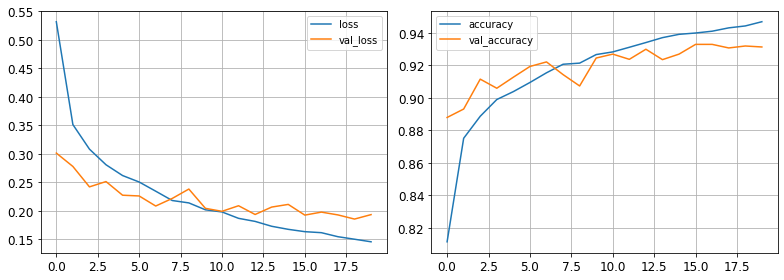

In [11]:
fig = plt.figure(figsize=[11, 4]) 
axes = fig.subplots(nrows=1, ncols=2)
for i, word in enumerate(["loss", "accuracy"]):
    for key, vals in history.history.items():
        if word in key:
            axes[i].plot(vals, label=key)
for ax in axes:
    ax.grid(), ax.legend()
fig.tight_layout()

# Save model and testset


## Mount google drive

In [12]:
mount_dir = os.path.join(os.getcwd(), "drive")
mount_dir

'/content/drive'

In [13]:
from google.colab import drive
drive.mount(mount_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## model.save()


In [14]:
save_dir = os.path.join(mount_dir, "My Drive", "Colab Notebooks", "models")
save_dir

'/content/drive/My Drive/Colab Notebooks/models'

In [0]:
fn = "fMNIST_CNN_v6_cmasch"
model.save(os.path.join(save_dir, fn + ".h5"))

### Save validation and test data along with the model

In [0]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [0]:
pickle_out(os.path.join(save_dir, fn + "_data.pkl"), locals(),
           X_valid, y_valid, X_test, y_test, class_names)

# Evaluate

In [18]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9314


[0.1934395134449005, 0.9314000010490417]